In [4]:
import sys
import os 
import numpy as np
import cv2
import imageio
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import albumentations as A
import gc

from datetime import datetime
from pathlib import Path
from PIL import Image
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Input, 
    Conv2D,
    MaxPooling2D,
    Dropout,
    Conv2DTranspose,
    concatenate
)

In [5]:
ROOT_DIR = globals()['_dh'][0]
PROJECT_DIR = ROOT_DIR.parent
DATA_DIR = PROJECT_DIR / "data"
WEIGHTS_DIR = PROJECT_DIR / "weights"
TRAIN_DIR = DATA_DIR / "train_subset"
VALID_DIR = DATA_DIR / "val_subset"
MEDIA_DIR = PROJECT_DIR / "media"

IMG_HEIGHT = 128
IMG_WIDTH = 128
N_CHANNELS = 3
MASK_CHANNELS = 1
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)
BATCH_SIZE = 32
EPOCHS = 10

IMG_TYPE = "jpg"
MASK_TYPE = "png"

K = keras.backend

sys.path.append(str(PROJECT_DIR))

In [6]:
from model import unet_model
from utils import *
from data_generators import DataGenerator

File structure must be like

train/val/test set dir
- images 
- - img1.jpg
- - img2.jpg
- - img3.jpg
- - ...

- masks
- - mask1.jpg
- - mask2.jpg
- - mask3.jpg
- - ... 

In [7]:
assert (TRAIN_DIR / "images").exists(), "Images not found in train directory"
assert (TRAIN_DIR / "masks").exists(), "Masks not found in train directory"

assert (VALID_DIR / "images").exists(), "Images not found in valid directory"
assert (VALID_DIR / "masks").exists(), "Masks not found in valid directory"

# Data Generator

## Simple Generator

In [8]:
image_list_ds = tf.data.Dataset.list_files(str(TRAIN_DIR / "images"), shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(str(TRAIN_DIR / "masks"), shuffle=False)

In [9]:
images_path = TRAIN_DIR / "images"
masks_path = TRAIN_DIR / "masks"

fnames_stem = [Path(fname).stem for fname in os.listdir(images_path)]

images_list = [str(images_path / f"{stem}.{IMG_TYPE}") for stem in fnames_stem]
masks_list = [str(masks_path / f"{stem}.{MASK_TYPE}") for stem in fnames_stem]


image_filenames = tf.constant(images_list)
masks_filenames = tf.constant(masks_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'd:\\Python\\WINSTARS\\test-task\\data\\train_subset\\images\\0011c31b7.jpg', shape=(), dtype=string)
tf.Tensor(b'd:\\Python\\WINSTARS\\test-task\\data\\train_subset\\masks\\0011c31b7.png', shape=(), dtype=string)


In [10]:
def process_path(image_path:Path, mask_path:Path, mask_channels:int=1, img_type:str=IMG_TYPE, mask_type:str=MASK_TYPE):
    """ This function takes an image and mask path and returns the image and mask as tensors """

    if img_type == "png":
        image_decoder = tf.image.decode_png
    
    elif img_type == "jpg":
        image_decoder = tf.image.decode_jpeg
    
    elif img_type == "npy":
        raise NotImplementedError("Numpy files not supported yet")

    else:
        raise ValueError(f"Invalid image type: {img_type}")
    

    if mask_type == "png":
        mask_decoder = tf.image.decode_png

    elif mask_type == "jpg":
        mask_decoder = tf.image.decode_jpeg

    elif mask_type == "npy":
        raise NotImplementedError("Numpy files not supported yet")
    
    else:
        raise ValueError(f"Invalid mask type: {mask_type}")


    img = tf.io.read_file(image_path)
    img = image_decoder(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = mask_decoder(mask, channels=mask_channels)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    if mask_channels == 3:
        mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    
    return img, mask

def preprocess(image, mask):
    """ This function takes an image and mask and resizes them to IMG_HEIGHT and IMG_WIDTH """

    input_image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH), method='nearest')
    input_mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH), method='nearest')

    return input_image, input_mask


image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [11]:
index = 8
for img, mask in processed_image_ds.take(index):
    pass

# img, mask = next(iter(processed_image_ds))

In [12]:
img.shape, mask.shape

(TensorShape([128, 128, 3]), TensorShape([128, 128, 1]))

In [13]:
tf.reduce_min(img), tf.reduce_max(img), tf.reduce_min(mask), tf.reduce_max(mask)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7254902>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.003921569>)

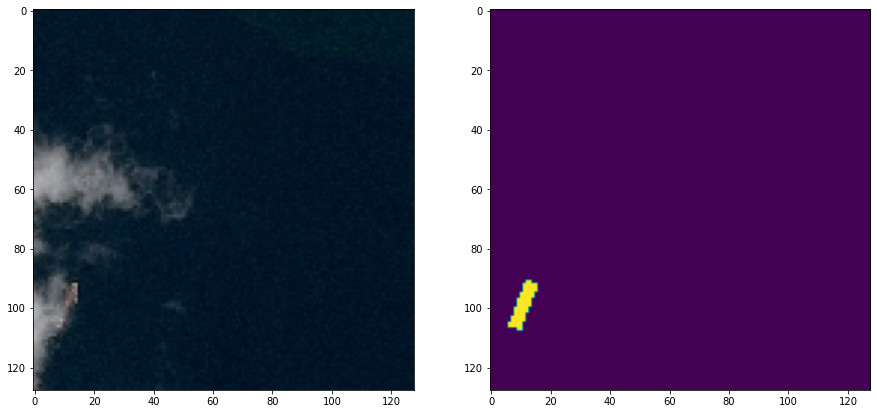

In [14]:
plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

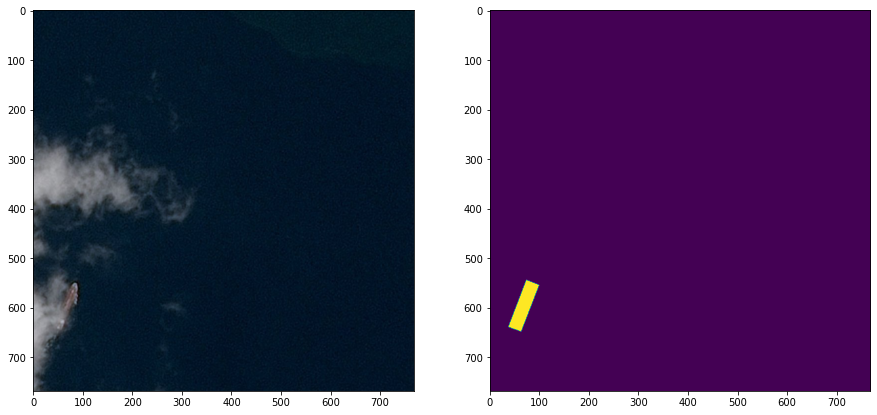

In [15]:
fname = fnames_stem[index-1]
img = imageio.imread(TRAIN_DIR / "images" / f"{fname}.{IMG_TYPE}")
mask = imageio.imread(TRAIN_DIR / "masks" / f"{fname}.{MASK_TYPE}")

plt.figure(figsize=(15, 10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

In [17]:
train_dataset = processed_image_ds.cache().shuffle(EPOCHS).batch(BATCH_SIZE)

## Custom generator from folder

In [18]:
transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.Rotate(p=0.5),        
    A.HorizontalFlip(p=0.5), 
    A.VerticalFlip(p=0.5),
    A.Blur(p=0.2),
    A.GaussNoise(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomRain(p=0.2),
    A.RandomFog(p=0.2),
])

Class DataGenerator defined at data_generators.py

In [19]:
data_generator = DataGenerator(
    images_path=TRAIN_DIR / "images",
    masks_path=TRAIN_DIR / "masks",
    image_type=IMG_TYPE,
    mask_type=MASK_TYPE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    height=IMG_HEIGHT,
    width=IMG_WIDTH,
    mask_channels=MASK_CHANNELS,
    transform=transform
)

valid_data_generator = DataGenerator(
    images_path=VALID_DIR / "images",
    masks_path=VALID_DIR / "masks",
    image_type=IMG_TYPE,
    mask_type=MASK_TYPE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    height=IMG_HEIGHT,
    width=IMG_WIDTH,
    mask_channels=MASK_CHANNELS,
    transform=None
)

Transforming the DataGenerator into a tf.data.Dataset to access the prefetch method, which will save some time during training.

In [20]:
def generator():
    for i in range(len(data_generator)):
        batch_X, batch_y = data_generator[i]
        yield batch_X, batch_y


def valid_generator():
    for i in range(len(valid_data_generator)):
        batch_X, batch_y = valid_data_generator[i]
        yield batch_X, batch_y


dataset = tf.data.Dataset.from_generator(generator, output_signature=(
    tf.TensorSpec(shape=(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS), dtype=tf.float32),
    tf.TensorSpec(shape=(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, MASK_CHANNELS), dtype=tf.float32)
))

valid_dataset = tf.data.Dataset.from_generator(valid_generator, output_signature=(
    tf.TensorSpec(shape=(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS), dtype=tf.float32),
    tf.TensorSpec(shape=(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, MASK_CHANNELS), dtype=tf.float32)
))

# Model

unet_model defined at model.py

In [21]:
model = unet_model(IMG_SHAPE, n_classes=1)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [23]:
model.compile(
    optimizer="adam",
    # loss="binary_crossentropy",
    loss=bce_dice_loss,
    metrics=["accuracy", dice_score]
)

In [24]:
save_model_path = WEIGHTS_DIR / 'best-model.hdf5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)


In [25]:
model_history = model.fit(
    dataset, 
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[checkpoint_callback]    
)

Epoch 1/10


    312/Unknown - 198s 608ms/step - loss: 1.0195 - accuracy: 0.9941 - dice_score: 0.0076WARNING:tensorflow:Can save best model only with val_dice_loss available, skipping.
312/312 [==============================] - 213s 657ms/step - loss: 1.0195 - accuracy: 0.9941 - dice_score: 0.0076 - val_loss: 0.9925 - val_accuracy: 0.9991 - val_dice_score: 0.0174
Epoch 2/10
312/312 [==============================] - 197s 631ms/step - loss: 0.9871 - accuracy: 0.9968 - dice_score: 0.0322 - val_loss: 0.9575 - val_accuracy: 0.9974 - val_dice_score: 0.0547
Epoch 3/10
312/312 [==============================] - 200s 643ms/step - loss: 0.9481 - accuracy: 0.9967 - dice_score: 0.0746 - val_loss: 0.9502 - val_accuracy: 0.9927 - val_dice_score: 0.0814
Epoch 4/10
312/312 [==============================] - 199s 638ms/step - loss: 0.9259 - accuracy: 0.9979 - dice_score: 0.0900 - val_loss: 0.8843 - val_accuracy: 0.9987 - val_dice_score: 0.1251
Epoch 5/10
312/312 [==============================] - 190s 608ms/step -

Figure saved to d:\Python\WINSTARS\test-task\media\training_history_2023-11-19_03-03-32.png


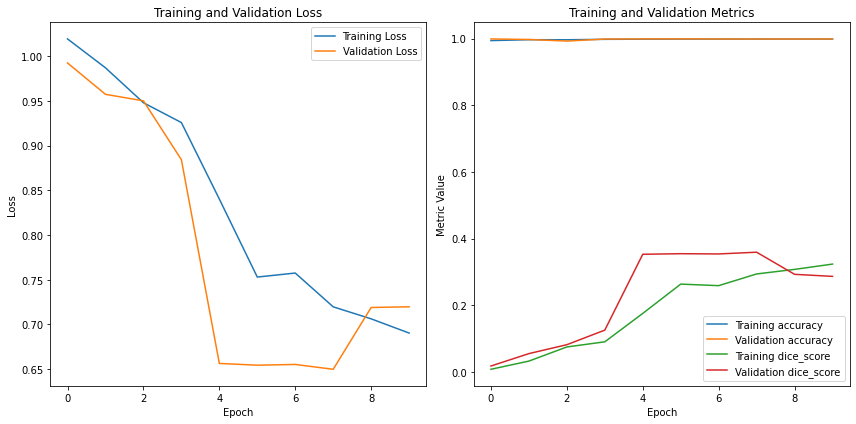

In [29]:
plot_training_history(model_history, metrics=["accuracy", "dice_score"], save_dir=MEDIA_DIR)

From the plot, it is evident that we can continue training further, but for the sake of this example, let's stop at this point.

In [41]:
strtime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model.save_weights(WEIGHTS_DIR / f"unet_weights_10e_32b_bcediceloss_{strtime}.h5")

In [33]:
img = imageio.imread(DATA_DIR / "test_v2" / "2693e39c1.jpg")
img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
img = img / 255.0

img = np.expand_dims(img, axis=0)
predicted_mask = model.predict(img)[0]

1/1 [==============================] - 1s 1s/step


In [34]:
predicted_mask.min(), predicted_mask.max()

(3.8373676e-17, 0.99999976)

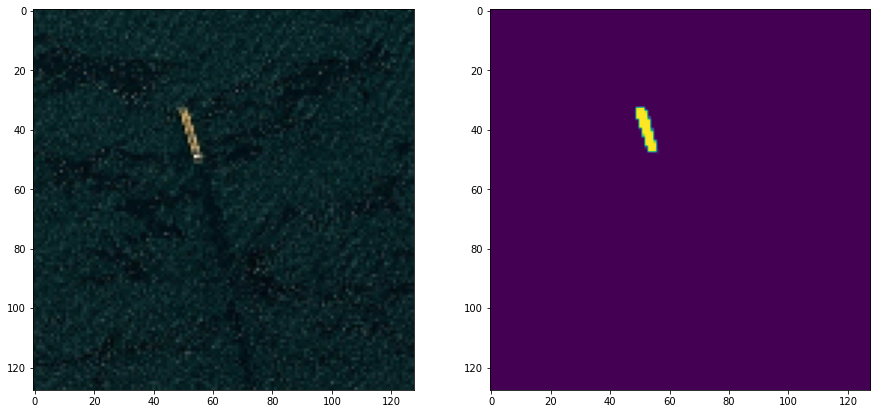

In [39]:
plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
plt.imshow(img[0])
plt.subplot(1,2,2)
plt.imshow(predicted_mask)
plt.show()
